# Random Forest Classifier: Landslide vs Non-Landslide

Binary classification using **raw raster pixel values** as features.

**Data:**
- 109 landslide rasters (label=1)
- 268 non-landslide rasters (label=0)
- Each raster: 5×5km at 10m resolution (~500×500 pixels)
- Each pixel value is used directly as a feature

In [1]:
import numpy as np
import rasterio
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Load All Rasters

In [2]:
raster_dir = Path("../Slope/Output/valid_rasters")

landslide_files = sorted(raster_dir.glob("landslide_*.tif"))
non_landslide_files = sorted(raster_dir.glob("no_landslide_*.tif"))

print(f"Landslide rasters: {len(landslide_files)}")
print(f"Non-landslide rasters: {len(non_landslide_files)}")
print(f"Total: {len(landslide_files) + len(non_landslide_files)}")

Landslide rasters: 109
Non-landslide rasters: 268
Total: 377


In [3]:
def load_raster_as_features(filepath):
    """Load raster and return flattened pixel values as features.
    
    Invalid values (outside 0-90 range) are replaced with 0.
    The entire raster is flattened into a 1D array.
    """
    with rasterio.open(filepath) as src:
        data = src.read(1).astype(np.float32)
    
    # Replace invalid values with 0
    invalid_mask = (data < 0) | (data > 90)
    data[invalid_mask] = 0
    
    # Flatten to 1D array - each pixel is a feature
    return data.flatten()

In [4]:
# Load raster pixels as features
print("Loading landslide rasters...")
X_landslide = []
for f in landslide_files:
    features = load_raster_as_features(f)
    X_landslide.append(features)
X_landslide = np.array(X_landslide)
y_landslide = np.ones(len(X_landslide))

print("Loading non-landslide rasters...")
X_non_landslide = []
for f in non_landslide_files:
    features = load_raster_as_features(f)
    X_non_landslide.append(features)
X_non_landslide = np.array(X_non_landslide)
y_non_landslide = np.zeros(len(X_non_landslide))

print(f"\nLoaded: {len(X_landslide)} landslide, {len(X_non_landslide)} non-landslide")

Loading landslide rasters...
Loading non-landslide rasters...

Loaded: 109 landslide, 268 non-landslide


In [5]:
# Combine datasets
X = np.vstack([X_landslide, X_non_landslide])
y = np.concatenate([y_landslide, y_non_landslide])

print(f"Total samples: {len(X)}")
print(f"Features per sample (pixels): {X.shape[1]}")
print(f"Raster dimensions: ~{int(np.sqrt(X.shape[1]))}x{int(np.sqrt(X.shape[1]))} pixels")
print(f"Class distribution: {int(sum(y))} landslide, {int(len(y)-sum(y))} non-landslide")

Total samples: 377
Features per sample (pixels): 251001
Raster dimensions: ~501x501 pixels
Class distribution: 109 landslide, 268 non-landslide


## 2. Train/Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training: {len(X_train)} samples")
print(f"  - Landslide: {int(sum(y_train))}")
print(f"  - Non-landslide: {int(len(y_train)-sum(y_train))}")
print(f"\nTest: {len(X_test)} samples")
print(f"  - Landslide: {int(sum(y_test))}")
print(f"  - Non-landslide: {int(len(y_test)-sum(y_test))}")

Training: 301 samples
  - Landslide: 87
  - Non-landslide: 214

Test: 76 samples
  - Landslide: 22
  - Non-landslide: 54


## 3. Train Random Forest

In [7]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest (this may take a while with many features)...")
rf.fit(X_train, y_train)
print("Model trained!")

Training Random Forest (this may take a while with many features)...
Model trained!


In [8]:
# Cross-validation score
print("Running cross-validation...")
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

Running cross-validation...
Cross-validation accuracy: 0.714 (+/- 0.009)


## 4. Evaluate Model

In [9]:
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("=" * 50)
print("CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=['Non-Landslide', 'Landslide']))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

CLASSIFICATION REPORT
               precision    recall  f1-score   support

Non-Landslide       0.71      1.00      0.83        54
    Landslide       0.00      0.00      0.00        22

     accuracy                           0.71        76
    macro avg       0.36      0.50      0.42        76
 weighted avg       0.50      0.71      0.59        76


Accuracy: 0.711
ROC-AUC: 0.637


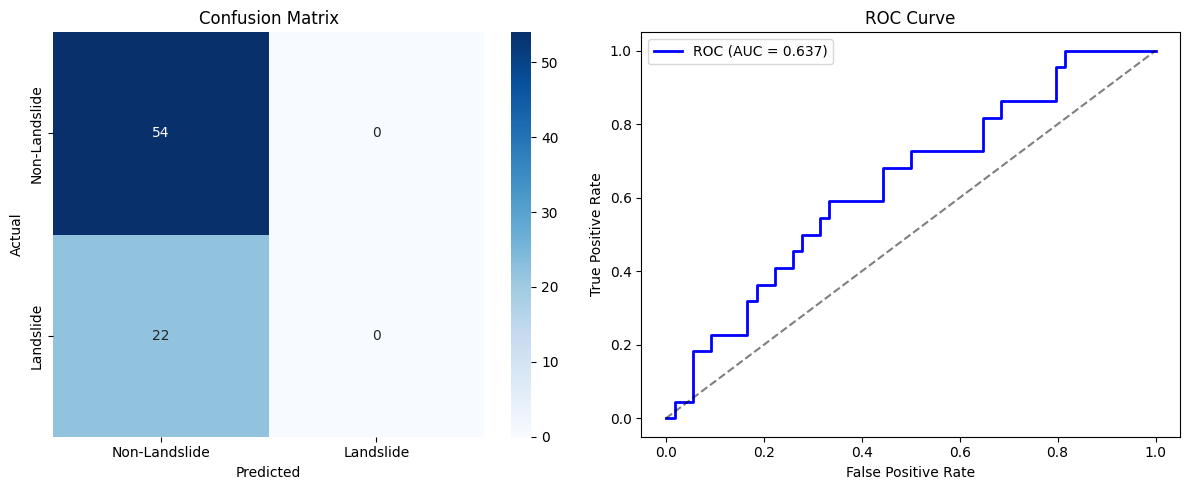

In [10]:
# Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non-Landslide', 'Landslide'],
            yticklabels=['Non-Landslide', 'Landslide'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

fpr, tpr, _ = roc_curve(y_test, y_proba)
axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba):.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Feature Importance Map

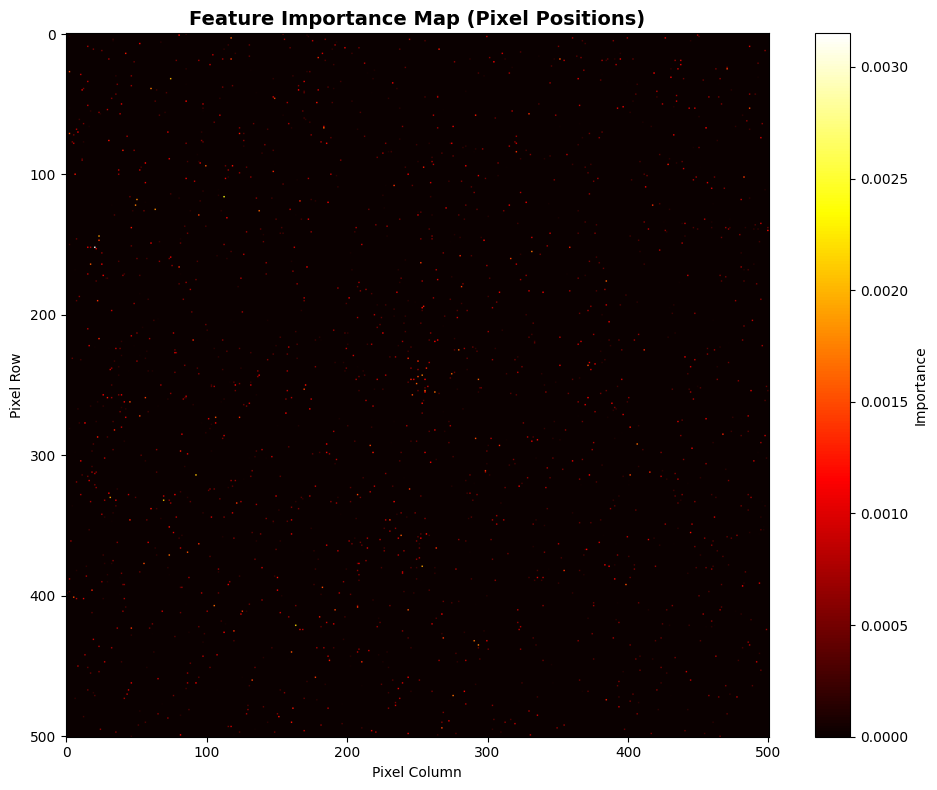


Top 10 most important pixel positions:
  1. Pixel (152, 20): importance = 0.003150
  2. Pixel (116, 112): importance = 0.002392
  3. Pixel (421, 163): importance = 0.002174
  4. Pixel (332, 69): importance = 0.002099
  5. Pixel (314, 92): importance = 0.002055
  6. Pixel (32, 74): importance = 0.002013
  7. Pixel (379, 253): importance = 0.001922
  8. Pixel (330, 31): importance = 0.001922
  9. Pixel (144, 23): importance = 0.001893
  10. Pixel (125, 63): importance = 0.001811


In [11]:
# Visualize feature importance by pixel position
importances = rf.feature_importances_
n_pixels_side = int(np.sqrt(len(importances)))
importance_map = importances.reshape(n_pixels_side, n_pixels_side)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(importance_map, cmap='hot')
ax.set_title('Feature Importance Map (Pixel Positions)', fontsize=14, fontweight='bold')
ax.set_xlabel('Pixel Column')
ax.set_ylabel('Pixel Row')
plt.colorbar(im, ax=ax, label='Importance')
plt.tight_layout()
plt.show()

print(f"\nTop 10 most important pixel positions:")
top_indices = np.argsort(importances)[-10:][::-1]
for i, idx in enumerate(top_indices):
    row, col = divmod(idx, n_pixels_side)
    print(f"  {i+1}. Pixel ({row}, {col}): importance = {importances[idx]:.6f}")